# Simulating Income
#### Ari Boyarsky
##### aboyarsky@uchicago.edu

### Introduction

We assume the income process is generated by:

$$\ln(inc_{2019}) = \ln(inc_0) + \epsilon_{2019}$$

$$\ln(inc_t) = (1-\rho)[\ln(inc_0) + g(t-2019)] + \rho\ln(inc_{t-1}) + \epsilon_t \; \text{for} \; 2020 \leq t \leq 2058$$
    
Let $t \geq 2019$, that is $inc_0 \Rightarrow (t=2019)$, and $\rho \in [0,1)$. Also we assume that $\epsilon_t \sim N(0, \sigma^2)$.

Please note: We drop the log of error terms that is listed in the original assignment as these are already in logorithmic form.

### Problem 1

First, we assume $\sigma = 0.1$, $\rho = 0.2$, $g=0.03$, and average initial income, $inc_0 = \$ 80,000$. Also, $\Delta t = 40$, from (2019 to 2058). 

In [81]:
# import nesc. packages
import matplotlib.pyplot as plot
import matplotlib.mlab as mlab
import numpy as np
import random
import scipy.stats as stats

# define parameters
i_avg = 80000
s = 0.1
p = 0.2
g = 0.03
t = 2019


First, we define our model:

In [82]:
# this is our income function for an individual at time t
# TODO: check the loged error term seems wrong

def inc_t(inc_avg, inc_last, persist, growth, time, error_t):
    return ((1-persist)*(np.log(inc_avg) + (growth*(time - 2019))) +
        ((persist)*(inc_last)) + error_t)

def inc_2019(inc_avg, error_2019):
    return (np.log(inc_avg) + error_2019)

Now, that we have defined our income functions we begin to simulate the process. We will simulate 10,000 outcomes.
We begin by drawing 40 normally distributed errors, 10,000 times. We assume the error is normally distributed with mean 0, and standard deviation, 0.1.


In [83]:
errors = []
for i in range(0, 10000):
    # draw from normal and append to errors
    errors.append(np.random.normal(0, s, 40))

For each year we use one of the error terms. This is done 10,000 times to simulate 10,000 possible income paths.

In [84]:
income_paths = [dict() for x in range(10000)]

# begin liftime income path
path = 0

# run simulation
for year in errors:
    # calculate 2019 income after graduation
    inc2019 = inc_2019(np.abs(i_avg), year[0])
    income_paths[path][t] = inc2019
    for i in range(1,40):
        t += 1
        income_paths[path][t] = inc_t(i_avg, income_paths[path][t-1], p, g, t, year[i])
    path += 1
    t = 2019

We plot the trend for a random timeline:

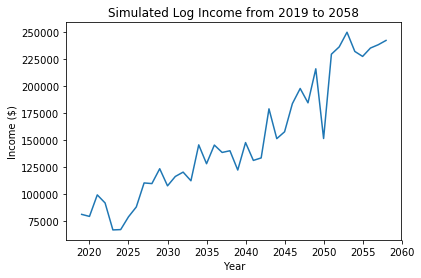

In [85]:
path = random.randint(0, 10000)
x,y = zip(*income_paths[path].items())
plot.plot(x,np.exp(y))
plot.xlabel("Year")
plot.ylabel("Income ($)")
plot.title("Simulated Log Income from 2019 to 2058")
plot.show()

### Problem 2

Below we plot a 50-bin histogram of 2019 income:

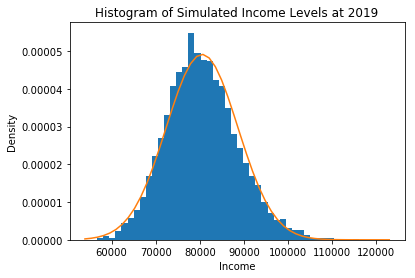

In [86]:
incs_2019 = [path.get(2019) for path in income_paths]
plot.hist(np.exp(incs_2019), 50, normed=True)
x = np.linspace(min(np.exp(incs_2019)), max(np.exp(incs_2019)), 50)
mu = np.mean(np.exp(incs_2019))
sd = np.sqrt(np.var(np.exp(incs_2019)))
plot.plot(x, mlab.normpdf(x, mu, sd))
plot.xlabel("Income")
plot.ylabel("Density")
plot.title("Histogram of Simulated Income Levels at 2019")
plot.show()

This does appear to be normally distributed. However, to check we plot a QQ-plot.

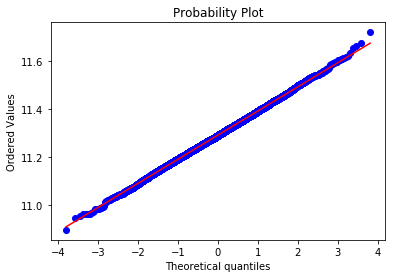

In [87]:
stats.probplot(incs_2019, dist="norm", plot=plot)
plot.show()

This is clearly a normal distribution based on the above plot.

What percent of the class will earn more than $100,000 in the first year?

In [88]:
count = [inc for inc in incs_2019 if np.exp(inc) > 100000]
print(str(round(len(count)/len(incs_2019)*100,4)) + "%")

1.51%


Under $70,000?

In [89]:
count = [inc for inc in incs_2019 if np.exp(inc) < 70000]
print(str(round(len(count)/len(incs_2019)*100,4)) + "%")

8.73%


### Problem 3

Given that you take a non-interest loan, L, of $95,000 and use r = 10% of salary to pay off the loan, the following simulation shows how long it will take to pay off said loan. 

First, we create the process by which an individual pays off a loan in a single time line (Note: that if someone pays off the loan in 2019, their time to pay off loan will be 0. That is, payment_times begin at 0):

In [90]:
def loan_payment_time(loan, pay_rate, income_path):
    t = 0
    for k,v in income_path.items():
        if loan > 0:
            payment = pay_rate*np.exp(v)
            loan = loan - payment
            t += 1
        else:
            break
    return t

Now, we define our parameters and run our simulation:

In [91]:
L = 95000
r = .1

payment_times = [loan_payment_time(L, r, path) for path in income_paths]

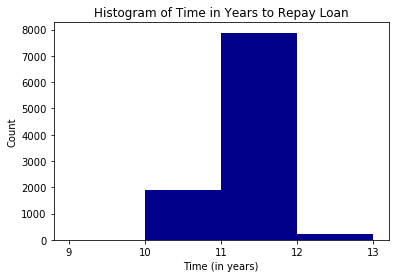

In [92]:
plot.hist(payment_times,color="darkblue", bins = np.arange(min(payment_times), max(payment_times)+2, 1.0))
plot.xticks(np.arange(min(payment_times), max(payment_times)+2, 1.0))
plot.ylabel("Count")
plot.xlabel("Time (in years)")
plot.title("Histogram of Time in Years to Repay Loan")
plot.show()

What percent of simulations is the loan payed off in 10 years or less?

In [93]:
count = [time for time in payment_times if time <= 10]
print(str(round(len(count)/len(payment_times)*100,4)) + "%")

18.98%


### Problem 4

Now, we reset our parameters given some exogenous shock that increases the income of MACSS gradautes. That is, $inc_0 = \$85,000$ and $\sigma = 0.15$. Given these changes we again evaluate the time to pay off a $95,000 loan.

First we define our new parameters and redraw our error terms:

In [94]:
i_avg = 85000
s = 0.15

errors = []
for i in range(0, 10000):
    # draw from normal and append to errors
    errors.append(np.random.normal(0, s, 40))

Now, we re-run our simulation:

In [95]:
income_paths = [dict() for x in range(10000)]

# begin liftime income path
path = 0

# run simulation
for year in errors:
    # calculate 2019 income after graduation
    inc2019 = inc_2019(np.abs(i_avg), year[0])
    income_paths[path][t] = inc2019
    for i in range(1,40):
        t += 1
        income_paths[path][t] = inc_t(i_avg, income_paths[path][t-1], p, g, t, year[i])
    path += 1
    t = 2019

And, we re-run the loan repayment simulation:

In [96]:
payment_times = [loan_payment_time(L, r, path) for path in income_paths]

Finally, we again generate our histogram of loan repayment and calculate the percentage of simulations in which the loan is repayed in 10 years or less.

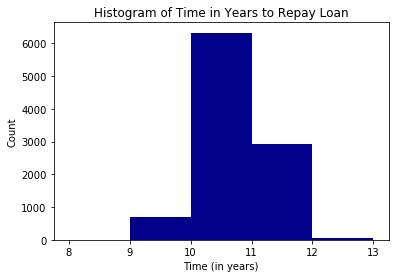

In [97]:
plot.hist(payment_times, bins = np.arange(min(payment_times), max(payment_times)+2, 1.0), color="darkblue")
plot.xticks(np.arange(min(payment_times), max(payment_times)+2, 1.0))
plot.ylabel("Count")
plot.xlabel("Time (in years)")
plot.title("Histogram of Time in Years to Repay Loan")
plot.show()

In [98]:
count = [time for time in payment_times if time <= 10]
print(str(round(len(count)/len(payment_times)*100,4)) + "%")

70.31%


In this world, we repay the loan in 10 years or less about 70% of the time.